## Problem Statement

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 


With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. 

<b>Note</b>: Some stores in the dataset were temporarily closed for refurbishment.

View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

<b> Files</b><br>
train.csv - historical data including Sales<br>
test.csv - historical data excluding Sales<br>
sample_submission.csv - a sample submission file in the correct format<br>
store.csv - supplemental information about the stores<br>

<b>Data fields</b>
Most of the fields are self-explanatory. The following are descriptions for those that aren't.<br>

Id - an Id that represents a (Store, Date) duple within the test set<br>
Store - a unique Id for each store<br>
Sales - the turnover for any given day (this is what you are predicting)<br>
Customers - the number of customers on a given day<br>
Open - an indicator for whether the store was open: 0 = closed, 1 = open<br>
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools<br>
StoreType - differentiates between 4 different store models: a, b, c, d<br>
Assortment - describes an assortment level: a = basic, b = extra, c = extended<br>
CompetitionDistance - distance in meters to the nearest competitor store<br>
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened<br>
Promo - indicates whether a store is running a promo on that day<br>
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2<br>
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Import Libraries

In [195]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

#### Configurations

In [196]:
pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)

# Import Datasets

In [197]:
ross_df = pd.read_csv('./input/rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./input/rossmann-store-sales/store.csv')
test_df = pd.read_csv('./input/rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./input/rossmann-store-sales/sample_submission.csv')

In [198]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [199]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


<b>Note :</b>
Customers column is present in train set(ross_df) but not in test set.<br>
Sales column is the target column.

In [200]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [201]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Since store_df contains additional information about the stores, let's merge store_df to the ross_df and test_df.<br>
`Left Outer Join` on the column name `Store`.

In [202]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [203]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [204]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# Preprocessing And Feature Engineering

In [205]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [271]:
def extract_date(data):
  
  # 将Date列转换为pandas的datetime类型
  data['Date'] = pd.to_datetime(data['Date'])  
  
  # 从日期中提取出年份信息,并创建新特征Year
  data['Year'] = data.Date.dt.year  

  # 从日期中提取出月份信息,并创建新特征Month
  data['Month'] = data.Date.dt.month

  # 从日期中提取出天信息,并创建新特征Day
  data['Day'] = data.Date.dt.day

  # 基于日期信息,提取每年的周数,并创建新特征WeekOfYear
  data['WeekOfYear'] = data.Date.dt.isocalendar().week

  # 注释:可选择删除原始的Date列
  #data.drop('Date', axis=1, inplace=True)

# 这个extract_date函数主要使用pandas的datetime功能,从日期时间类型的列中提取出年、月、天、周等时间信息,并构造为独立的特征列,便于后续建模分析。


In [207]:
extract_date(merged_df)
extract_date(merged_test_df)

In [208]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [209]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17,38
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2015,8,1,31
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31


<b>Note</b> : Date column in training set is the past (2013 - 2015) and that in the test set is the future(2015).<br>
Let's first extract different parts of the Date.

In [210]:
merged_df.Year.value_counts()

Year
2013    406974
2014    373855
2015    236380
Name: count, dtype: int64

In [211]:
merged_test_df.Year.value_counts()

Year
2015    41088
Name: count, dtype: int64

#### `Open` Column
The open column in the dataset describes whether the store is opened or not.<br>
And if the store is not opened on a day there will not be any Sales.<br>
It can be seen that the stores are closed for 172817 days (rows).<br>

In [212]:
#merged_df[merged_df.Open == 0].Sales.value_counts()
merged_df[merged_df.Open == 0].Sales

291        0
875        0
1406       0
1990       0
2521       0
          ..
1017204    0
1017205    0
1017206    0
1017207    0
1017208    0
Name: Sales, Length: 172817, dtype: int64

Therefore it is obvious that if a store is closed then the Sales on that day is zero.<br>
Therefore, let's drop all columns in the merged_df for which Open=0.<br>
And while predicting, Sales of merged_test_df = 0 when Open = 0.<br>

In [213]:
merged_df = merged_df[merged_df.Open == 1].copy()

### CompetitionOpenSinceMonth & CompetitionOpenSinceYear

- CompetitionOpenSinceYear : On which year the competitor store was opened.
- CompetitionOpenSinceMonth : On which month the competitor store was opened.

It will be helpful for our model if the duration of competition (number of months) is known instead of the exact date in which the competition store has opened.<br>
So, we'll use these two rows along with Year, Month columns to derive the duration column and use it to train our model.<br>

The longer the compititor store has opened, the more the more impact on the Sales of the store.

<b>Note : </b><br>
There are Nan Values also in `CompetitionOpenSinceYear` & `CompetitionOpenSinceMonth` which means there is no competition store nearby for which the value is to be replaced as zero.<br>

Also for a store there might not be competition in a particular date but the competition arises in future and in such cases the difference will be negative value.<br>

These are not relevant values since it represent the future in which the competition arises and also no competition.<br>
Therefore, negative and NaN values are replaced with zero.

In [214]:
merged_df[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Year', 'Month']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CompetitionOpenSinceMonth  575773 non-null  float64
 1   CompetitionOpenSinceYear   575773 non-null  float64
 2   Year                       844392 non-null  int32  
 3   Month                      844392 non-null  int32  
dtypes: float64(2), int32(2)
memory usage: 25.8 MB


In [215]:
def calc_duration_competition(data):
    # 在这里加对数据为空的处理
    data.loc[data.CompetitionOpenSinceYear.isnull(), 'CompetitionOpenSinceYear'] =0
    data.loc[data.CompetitionOpenSinceMonth.isnull(), 'Month']=0
    data.loc[data.CompetitionOpenSinceMonth.isnull(), 'CompetitionOpenSinceMonth']=0
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x:0 if x<0 else x).fillna(0)

In [216]:
calc_duration_competition(merged_df)
calc_duration_competition(merged_test_df)

In [217]:
merged_df[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Year', 'Month']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CompetitionOpenSinceMonth  844392 non-null  float64
 1   CompetitionOpenSinceYear   844392 non-null  float64
 2   Year                       844392 non-null  int32  
 3   Month                      844392 non-null  int32  
dtypes: float64(2), int32(2)
memory usage: 25.8 MB


In [218]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
450761,2014-05-24,2210.0,2011.0,11.0,30.0
702445,2013-10-10,630.0,2007.0,4.0,78.0
626767,2013-12-17,280.0,2008.0,9.0,63.0
960423,2013-02-20,3320.0,0.0,0.0,24156.0
497443,2014-04-12,1340.0,0.0,0.0,24168.0
471468,2014-05-05,2070.0,2007.0,9.0,80.0
596592,2014-01-13,14040.0,0.0,0.0,24168.0
372569,2014-08-08,11900.0,0.0,0.0,24168.0
355073,2014-08-27,13190.0,0.0,0.0,24168.0
743009,2013-09-03,330.0,2007.0,11.0,70.0


#### Promotion of Store
Promotions given by a store increases the sales.<br>

Promo - indicates whether a store is running a promo on that day<br>
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2<br>
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

We can also add some additional columns to indicate how long (Number of months) a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.<br>

<b>Note : </b>Here also negative values and NaN values are replaced as zero.

In [219]:
def check_promo_month(row):#check if promo is given in the particular month
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if(row['Promo2Open'] and month2str[row['Month']] in months):
            return 1
        else:
            return 0
    except:
        return 0
    
def promo_cols(data): #calculate duration of promotion(in months)
    data['Promo2Open'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek)*7/30.5
    # 修复类型报错data['Promo2']
    data.loc[data.Promo2SinceYear.isnull(), 'Promo2SinceYear'] = 0
    data.loc[data.Promo2SinceWeek.isnull(), 'Promo2SinceWeek'] = 0
    data.loc[data.Promo2.isnull(), 'Promo2'] = 0    
    data.loc[data.Promo2Open.isnull(), 'Promo2Open'] = 0
    data['Promo2Open'] = data['Promo2Open'].apply(lambda x: 0 if x < 0 else x).fillna(0)*data['Promo2']#only when there is promo
    #whether a new round of promotion started in curent month
    data['IsPromo2Month'] = data.apply(check_promo_month, axis=1) * data['Promo2']

In [220]:
%%time
# print('Before:', merged_df)
promo_cols(merged_df)
promo_cols(merged_test_df)

CPU times: user 3.82 s, sys: 114 ms, total: 3.94 s
Wall time: 3.94 s


In [221]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
222725,2015-01-13,0,0.0,0.0,NaN,0.000000,0
172149,2015-02-27,1,2009.0,45.0,"Feb,May,Aug,Nov",63.737705,1
768551,2013-08-12,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
494405,2014-04-14,0,0.0,0.0,NaN,0.000000,0
393237,2014-07-17,1,2010.0,13.0,"Jan,Apr,Jul,Oct",51.672131,0
1009736,2013-01-07,0,0.0,0.0,NaN,0.000000,0
878984,2013-05-04,1,2012.0,1.0,"Jan,Apr,Jul,Oct",15.901639,0
969553,2013-02-12,0,0.0,0.0,NaN,0.000000,0
399853,2014-07-10,0,0.0,0.0,NaN,0.000000,0
537760,2014-03-06,0,0.0,0.0,NaN,0.000000,0


# Input & Target Columns

In [222]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [223]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

- Date is dropped because all relevant information is extracted
- Sales is target column
- Customers is not present in test data so drop.( or create a model to predict number of customers and use the values in test data). 
- Open : Sales = 0 when Open =0 (obvious so not needed to feed into our model)
- 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear' is used to derive 'CompetitionOpen'
- 'Promo2SinceYear', 'PromoInterval' is used to derive 'Promo2Open', 'IsPromo2Month'

In [224]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
test_inputs = merged_test_df[input_cols].copy()

#### Numerical & Categorical Columns

In [225]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

# Impute Missing Numerical Data

In [226]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [227]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Only Competition Distance numerical column has null values.<br>
Competition Distance having null values means that there is no competitor store near by so these are to be imputed with `larger value constant` not zero (since larger the distance means lesser the competition).<br>

We'll impute with the maximum value.

In [228]:
max_distance = inputs.CompetitionDistance.max()
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

# Scaling Numerical Values

In [229]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [230]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/Users/callustang/miniconda3/envs/rossmann-sales-xgboost/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [231]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Gradient Boosting

In [232]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [233]:
%%time
model.fit(X, targets)

CPU times: user 14.3 s, sys: 1.68 s, total: 15.9 s
Wall time: 2.47 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

In [234]:
preds = model.predict(X)

In [235]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [236]:
rmse(preds, targets)

2381.83340717387

# Visualization

In [237]:
trees = model.get_booster().get_dump()
len(trees)

20

In [238]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00441719405] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.01602057] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.0134493671] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[WeekOfYear<0.931372523] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[WeekOfYear<0.931372523] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.002703059] yes=27,no=28,missing=27
				2

# Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [239]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
1,Promo,0.315126
12,DayOfWeek_1,0.102333
24,StoreType_b,0.083057
5,Promo2,0.072147
2,SchoolHoliday,0.049360
29,Assortment_c,0.045408
3,CompetitionDistance,0.043257
0,Store,0.034689
11,WeekOfYear,0.030598
27,Assortment_a,0.030356


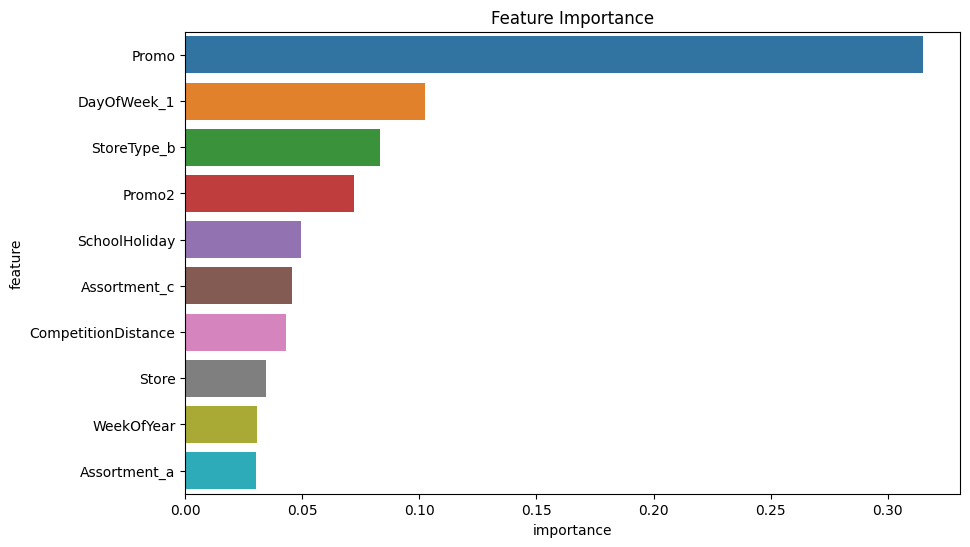

In [240]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

In [241]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [242]:
kfold = KFold(n_splits=5)

In [243]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2376.414495078917, Validation RMSE: 2464.6214926137764
Train RMSE: 2356.739613039104, Validation RMSE: 2436.5702061733136
Train RMSE: 2383.8221417813047, Validation RMSE: 2368.570601133414
Train RMSE: 2357.5284922500787, Validation RMSE: 2450.0940686983568
Train RMSE: 2378.4075461206567, Validation RMSE: 2431.423568606467


In [244]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [245]:
preds = predict_avg(models, X_train)
preds

array([8241.964 , 7715.7373, 8551.618 , ..., 7322.1865, 8623.646 ,
       7599.177 ], dtype=float32)

# Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [246]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [247]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [248]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [249]:
test_params(n_estimators=10)

Train RMSE: 2281.717555484889, Validation RMSE: 2290.177614490177


### max_depth

In [250]:
test_params(max_depth=2)

Train RMSE: 2345.15694619172, Validation RMSE: 2346.9842606643874


In [251]:
test_params(max_depth=5)

Train RMSE: 1371.2406038668817, Validation RMSE: 1379.0932281377402


#### learning_rate

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [252]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5043.622422053728, Validation RMSE: 5054.960856381087


In [253]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2131.4299543794846, Validation RMSE: 2140.1082205418293


#### booster

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [254]:
test_params(booster='gblinear')

Train RMSE: 2727.036785800368, Validation RMSE: 2727.3082099559983


# Train with best parameters

In [255]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [256]:
%%time
model.fit(X, targets)

CPU times: user 29min 21s, sys: 5min 55s, total: 35min 17s
Wall time: 5min 43s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Predict

In [257]:
test_preds = model.predict(X_test)

In [258]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [259]:
test_df.Open.isna().sum()

11

#### Preparing submission.csv

In [260]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [261]:
submission_df

,Id,Sales
0,1,3886.328125
1,2,7721.505859
2,3,9260.431641
3,4,7092.877441
4,5,7200.538086
...,...,...
41083,41084,2364.081055
41084,41085,6444.291504
41085,41086,6014.906250
41086,41087,23130.537109


In [262]:
submission_df.to_csv('submission.csv', index=None)

# Single Input Prediction

In [263]:
sample_input={
    'Store':2,
    'DayOfWeek':4,
    'Promo' :1,
    'Date':'2015-09-30',
    'Open':1,
    'StateHoliday':'a',
    'SchoolHoliday':0
}
input_df = pd.DataFrame([sample_input])
input_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday
0,2,4,1,2015-09-30,1,a,0


In [264]:
input_merged_df = input_df.merge(store_df, on='Store')
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2,4,1,2015-09-30,1,a,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# Saving & Loading Models

In [265]:
drug_store = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [266]:
joblib.dump(drug_store, 'drug_store.joblib')

['drug_store.joblib']

In [267]:
drug_store = joblib.load('drug_store.joblib')

#### Feature Engineering

In [272]:
# 提取日期信息作为特征
extract_date(input_merged_df)  

# 计算竞争持续时间作为特征
calc_duration_competition(input_merged_df)

# 增加促销相关特征
promo_cols(input_merged_df)

# 特征工程完成后的dataframe
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000898,4,1.0,2015-09-30,1,a,0.0,a,a,0.007252,11.0,2007.0,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,9,30,40,94.0,66.196721,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Preprocessing

In [269]:
input_merged_df[numeric_cols] = scaler.transform(input_merged_df[numeric_cols])
input_merged_df[encoded_cols] = encoder.transform(input_merged_df[categorical_cols])

In [270]:
X_input = input_merged_df[numeric_cols+encoded_cols]
model.predict(X_input)[0]

5915.1567